In [60]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [61]:
vgg = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU, so freezing beforehand would have no effect.

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)
for param in vgg.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto your GPU.

In [63]:
next(vgg.parameters()).is_cuda # Should be `True` if you have a GPU

True

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working

In [64]:
# vgg_layers = list(vgg.children())[0]

# for i in range(len(vgg_layers)):
#     if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
#         vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations. We also define `image_loader` a function which takes a relative image path, loads the image into a tensor, applies the relevant transformations to it and returns it.

We also define a convenience function `show_image` for viewing images we load using `image_loader`. For some reason pytorch doesn't seem to have any good way of visualizing tensors, so we convert the tensor to a numpy array, and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function used to add extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We definitely SHOULN'T add it here, or else our sample textures will be updated to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me.

In [65]:
transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out so we can see).

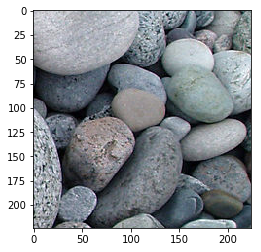

In [66]:
img_path = "data/examples/"
img_name = "stones.jpg"
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the gram matrices of the feature maps of all convolutional and pooling layers in vgg19. In order to copy them we're going to use pytorch's hook feature. 

### Hooks

Basically you define hooks as classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hooks `hook_fn` method on the layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. 

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor to the hook class instance for later use when called.

In [67]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

Next we iterate through all the layers in our model and register a hook instance on each of the convolutional or pooling layers.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list, but with vgg19 at least what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [68]:
example_features = []

for layer in list(vgg.children())[0]:
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        example_features.append(SaveFeatures(layer))

print(len(example_features)) # should be 21

21


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers. 

In [69]:
print(type(example_features[10].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(example_features[10].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([ 0.0000,  0.0000,  0.0000,  1.8631,  0.0000,  0.0000,  1.2486,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0954,  0.0000,  0.0000,
         0.0000,  0.0000,  1.8045,  2.7481, 13.1464,  0.1684,  0.1790,  5.9950,
         4.7977,  0.8635,  2.3364,  0.3289], device='cuda:0')


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes a layer's worth of feature maps and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [70]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input.

In [71]:
example_stats = [gram_matrix(layer.features) for layer in example_features]
print(len(example_stats)) # should be 21
print(example_stats[0]) # should be a tensor. It will probably have very small values.

21
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0029, 0.0000,  ..., 0.0000, 0.0014, 0.0022],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0014, 0.0000,  ..., 0.0000, 0.0014, 0.0018],
        [0.0000, 0.0022, 0.0000,  ..., 0.0000, 0.0018, 0.0028]],
       device='cuda:0')


## Computing Loss

Next we need a way of generating a loss given the example summary statistics (above), and some sample summary statistics (which we will generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because (as we can see above) the gram matrices we calculate from the feature maps tend to be pretty damn tiny), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was *literally* just to scale the loss by some factor before returning. Gross I know. If you can find something better PLEASE let me know.

In [72]:
scale = 100 
# ideally we would pass scale in as a parameter, but then we'd also need to pass it in to
# `closure()`, and the way we're using closure doesn't allow parameters.

def loss_fn(stats, target_stats):
    loss = 0
    for i in range(len(target_stats)):
        loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error
    
    print("scale: {}".format(scale))
    return loss * scale

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. Tl;dr: if you're using `torch.optim.LBFGS()` you can't just call `.step()` like normal, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class around it and use attribute variables on that class as parameters

As we can see, on each step we generate summary statistics on the sample texture just like we did for the example texture, and then compute the loss between these two. The optimizer we're about ti define will then perform the gradient update on the sample.

In [80]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, example_features, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.example_features = example_features
        self.scale = scale

    def closure(self):
        self.optimizer.zero_grad() # SUPER important. If you don't understand why I am doing this 
                              # please read up on autograd and savbe yourself the carnage.

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.example_features]

        loss = loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss

## Create the Sample Texture

Nearly there! Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it until its summary statistics (i.e. gram matrices) more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them, so it should be easier to turn a smoothened random image into a natural looking image than a truly random one.


torch.Size([1, 3, 224, 224])


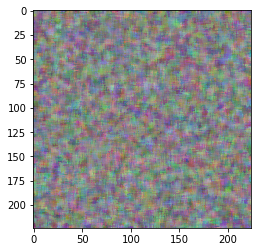

In [77]:
# create random noise numpy array
np_sample = np.random.rand(224, 224, 3)

# smooth it out (try commenting out this line and see the difference)
np_sample = scipy.ndimage.filters.median_filter(np_sample, [6, 6,1]) 

# finally convert to a tensor with autograd enabled (since we're 
# going to be performing gradient updates on this image)
sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
sample.requires_grad = True

# optim.LBFGS() expects parameters to be passed in as an iterable, so I put my single parameter
# in a list.
optimizer = optim.LBFGS([sample], lr=0.1) 

print(sample.size())
show_image(sample)

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture and once that's done it should look a bit like the example texture (hopefully).

### Viewing Images

First things first, rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going.


### Scale

This is the nasty hack I mentioned earlier. My idea is to decrease the loss's scaling as we go so that as training proceeds we'll be making smaller and smaller gradient updates. Basically I'm kind of treating this like a learning rate.

We can't just use a normal learning rate instead, because if we don't scale the loss the gradient is always zero, and no amount of learning rate scaling will save us.


In [82]:
view = 1
scale = 10000
dirname = "halving-loss-avg-pool-" + img_name # i've been renaming this after the hyperparameters or 
                                              # approaches I've been using
dir_path = "data/samples/{}".format(dirname)

stepper = GradientStepper(optimizer, vgg, sample, example_features)

if not os.path.exists(dir_path):
    os.makedirs(dir_path)

for i in range (129): # arbitrary number
    if sample.grad is not None:
        print(sample.grad[0][0][0][:4])
    
    optimizer.step(stepper.closure)
    
    # occationally save an image so see how generation is going
    if i == view:
        save_image(sample, "data/samples/{}/lbfgs-{}.jpg".format(dirname, view))
        view += view
        scale -= (scale / 2)

print("sample texture finished")

NameError: name 'self' is not defined